# AutoGluon Example on Custom Dataset

**Import the basic packages, such as numpy, mxnet and gluoncv.**

In [1]:
import os
import time
import logging
import numpy as np

import mxnet as mx
from mxnet import gluon, init
from gluoncv.model_zoo import get_model


**Define a function to load the given network parameters**

In [2]:
def get_network(num_classes, ctx):
    finetune_net = get_model('densenet169', pretrained=False)
    finetune_net.collect_params().load('densenet169-0000.params')
    # change the last fully connected layer to match the number of classes
    with finetune_net.name_scope():
        finetune_net.output = gluon.nn.Dense(num_classes)
    # initialize and context
    finetune_net.output.initialize(init.Xavier(), ctx=ctx)
    finetune_net.collect_params().reset_ctx(ctx)
    finetune_net.hybridize()
    return finetune_net

**Define a function for dataset meta data**

In [3]:
def get_dataset_meta(dataset, basedir='./datasets'):
    if dataset.lower() == 'apparel':
        num_classes = 18
        rec_train = os.path.join(basedir, 'Apparel_train.rec')
        rec_train_idx = os.path.join(basedir, 'Apparel_train.idx')
        rec_val = os.path.join(basedir, 'Apparel_test.rec')
        rec_val_idx = os.path.join(basedir, 'Apparel_test.idx')
    else:
        raise NotImplemented
    return num_classes, rec_train, rec_train_idx, rec_val, rec_val_idx

**Define the test/evaluation function**

In [4]:
def test(net, val_data, ctx, batch_fn):
    metric = mx.metric.Accuracy()
    val_data.reset()
    for i, batch in enumerate(val_data):
        data, label = batch_fn(batch, ctx)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

**Define the training loop**
This is a 40-line normal finetuning script, with only basic components:

In [5]:
def train_loop(args, reporter):
    lr_steps = [int(args.epochs*0.75), np.inf]
    ctx = [mx.gpu(i) for i in range(args.num_gpus)] if args.num_gpus > 0 else [mx.cpu()]

    num_classes, rec_train, rec_train_idx, rec_val, rec_val_idx = get_dataset_meta(args.dataset)
    finetune_net = get_network(num_classes, ctx)

    train_data, val_data, batch_fn = get_data_rec(
            args.input_size, args.crop_ratio, rec_train, rec_train_idx,
            rec_val, rec_val_idx, args.batch_size, args.num_workers,
            args.jitter_param, args.max_rotate_angle)

    trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
                            'learning_rate': args.lr, 'momentum': args.momentum, 'wd': args.wd})
    metric = mx.metric.Accuracy()
    L = gluon.loss.SoftmaxCrossEntropyLoss()

    lr_counter = 0
    for epoch in range(args.epochs):
        if epoch == lr_steps[lr_counter]:
            print('Decreasing LR to ', trainer.learning_rate*args.lr_factor)
            trainer.set_learning_rate(trainer.learning_rate*args.lr_factor)
            lr_counter += 1

        train_data.reset()
        metric.reset()
        for i, batch in enumerate(train_data):
            data, label = batch_fn(batch, ctx)
            with mx.autograd.record():
                outputs = [finetune_net(X) for X in data]
                loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
            for l in loss:
                l.backward()

            trainer.step(args.batch_size)
            metric.update(label, outputs)

        _, train_acc = metric.get()
        _, val_acc = test(finetune_net, val_data, ctx, batch_fn)

        if reporter is not None:
            # reporter enables communicatons with autogluon
            reporter(epoch=epoch, accuracy=val_acc)
        else:
            print('[Epoch %d] Train-acc: %.3f | Val-acc: %.3f' %
                  (epoch, train_acc, val_acc))

### How to convert any training function to enable autogluon HPO?

In [6]:
import autogluon as ag
from autogluon import autogluon_register_args
from autogluon.utils.mxutils import get_data_rec

In [7]:
@autogluon_register_args(
    dataset='apparel',
    resume=False,
    epochs=ag.ListSpace(80, 40, 120),
    lr=ag.LogLinearSpace(1e-4, 1e-2),
    lr_factor=ag.LogLinearSpace(0.1, 1),
    batch_size=256,
    momentum=0.9,
    wd=ag.LogLinearSpace(1e-5, 1e-3),
    num_gpus=8,
    num_workers=30,
    input_size=ag.ListSpace(224, 256),
    crop_ratio=0.875,
    jitter_param=ag.LinearSpace(0.1, 0.4),
    max_rotate_angle=ag.IntSpace(0, 10),
    remote_file='remote_ips.txt',
)
def train_finetune(args, reporter):
    return train_loop(args, reporter)

### Create the searcher and scheduler

In [8]:
searcher = ag.searcher.RandomSampling(train_finetune.cs)
args =  train_finetune.args
myscheduler = ag.distributed.DistributedFIFOScheduler(train_finetune,args,
                                                      resource={'num_cpus': 16, 'num_gpus': args.num_gpus},
                                                      searcher=searcher,
                                                      checkpoint='./{}/checkerpoint.ag'.format(args.dataset),
                                                      num_trials=25,
                                                      resume=args.resume,
                                                      time_attr='epoch',
                                                      reward_attr="accuracy")
print(myscheduler)

[ scheduler local ] : distributed.scheduler - INFO - -----------------------------------------------
[ worker local ] : distributed.diskutils - INFO - Found stale lock file and directory '/home/ubuntu/git/AutoGluon/examples/worker-4ihee08g', purging
[ scheduler local ] : distributed.scheduler - INFO - Clear task state
[ worker local ] : distributed.worker - INFO -       Start worker at:  tcp://172.31.23.121:36234
[ worker local ] : distributed.worker - INFO -          Listening to:  tcp://172.31.23.121:36234
[ worker local ] : distributed.worker - INFO -          dashboard at:        172.31.23.121:40975
[ worker local ] : distributed.worker - INFO - Waiting to connect to:   tcp://172.31.23.121:8781
[ worker local ] : distributed.worker - INFO - -------------------------------------------------
[ worker local ] : distributed.worker - INFO -               Threads:                         64
[ worker local ] : distributed.worker - INFO -                Memory:                  515.70 GB
[

**Run the experiments**

In [9]:
myscheduler.run()

[ scheduler local ] : distributed.scheduler - INFO - Receive client connection: Client-worker-ebe49d02-b8d3-11e9-97a6-0d0563c5becd
[ scheduler local ] : distributed.core - INFO - Starting established connection
[ worker local ] : [05:27:04] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_train.rec, use 30 threads for decoding..
[ worker local ] : [05:27:05] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_test.rec, use 30 threads for decoding..
[ worker local ] : [05:27:07] src/kvstore/././comm.h:744: only 32 out of 56 GPU pairs are enabled direct access. It may affect the performance. You can set MXNET_ENABLE_GPU_P2P=0 to turn it off
[ worker local ] : [05:27:07] src/kvstore/././comm.h:753: .vvvv...
[ worker local ] : [05:27:07] src/kvstore/././comm.h:753: v.vv.v..
[ worker local ] : [05:27:07] src/kvstore/././comm.h:753: vv.v..v.
[ worker local ] : [05:27:07] src/kvstore/././comm.h:753: vvv....v
[ worker local ] : [05:27:07] 

[ worker local ] : [05:49:54] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[ worker local ] : [05:50:06] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[ worker local] : rec_train ./datasets/Apparel_train.rec
[ worker local] : rec_train_idx ./datasets/Apparel_train.idx
[ worker local] : Decreasing LR to  0.004921331937756977
[ worker local ] : [06:01:50] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_train.rec, use 30 threads for decoding..
[ worker local ] : [06:01:50] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_test.rec, use 30 threads for decoding..
[ worker local ] : [06:01:53] src/

[ worker local ] : [06:48:58] src/kvstore/././comm.h:744: only 32 out of 56 GPU pairs are enabled direct access. It may affect the performance. You can set MXNET_ENABLE_GPU_P2P=0 to turn it off
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: .vvvv...
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: v.vv.v..
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: vv.v..v.
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: vvv....v
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: v....vvv
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: .v..v.vv
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: ..v.vv.v
[ worker local ] : [06:48:58] src/kvstore/././comm.h:753: ...vvvv.
[ worker local ] : [06:49:06] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[ worker local ] : [06:

[ worker local ] : [07:19:16] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[ worker local] : rec_train ./datasets/Apparel_train.rec
[ worker local] : rec_train_idx ./datasets/Apparel_train.idx
[ worker local] : Decreasing LR to  0.0007869914023039594
[ worker local ] : [07:27:16] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_train.rec, use 30 threads for decoding..
[ worker local ] : [07:27:16] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_test.rec, use 30 threads for decoding..
[ worker local ] : [07:27:19] src/kvstore/././comm.h:744: only 32 out of 56 GPU pairs are enabled direct access. It may affect the performance. You can set MXNET_ENABLE_GPU_P2P=0 to turn it off
[ worker local ] : [07:27:19] src/kvstore/././comm.h:753: .vvvv...
[ worker local ] : 

**Join the tasks and gather the results**

[ worker local ] : [07:39:05] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_train.rec, use 30 threads for decoding..
[ worker local ] : [07:39:05] src/io/iter_image_recordio_2.cc:172: ImageRecordIOParser2: ./datasets/Apparel_test.rec, use 30 threads for decoding..
[ worker local ] : [07:39:08] src/kvstore/././comm.h:744: only 32 out of 56 GPU pairs are enabled direct access. It may affect the performance. You can set MXNET_ENABLE_GPU_P2P=0 to turn it off
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: .vvvv...
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: v.vv.v..
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: vv.v..v.
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: vvv....v
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: v....vvv
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: .v..v.vv
[ worker local ] : [07:39:08] src/kvstore/././comm.h:753: ..v.vv.v
[ worker local ] : [07:39:08] src/kvstor

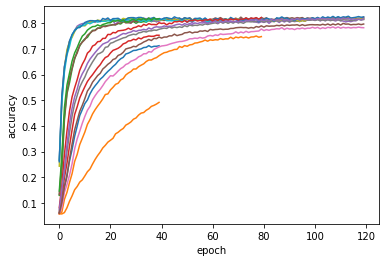

The Best Configuration and Accuracy are: {'epochs': 80, 'input_size': 256, 'jitter_param': 0.31224133807497123, 'lr': 0.004884731644321022, 'lr_factor': 0.4133816243832498, 'max_rotate_angle': 6, 'wd': 0.0007086285768674665}, 0.8277529761904762


In [10]:
myscheduler.join_tasks()
myscheduler.get_training_curves(plot=True,use_legend=False)
print('The Best Configuration and Accuracy are: {}, {}'.format(myscheduler.get_best_config(),
                                                               myscheduler.get_best_reward()))